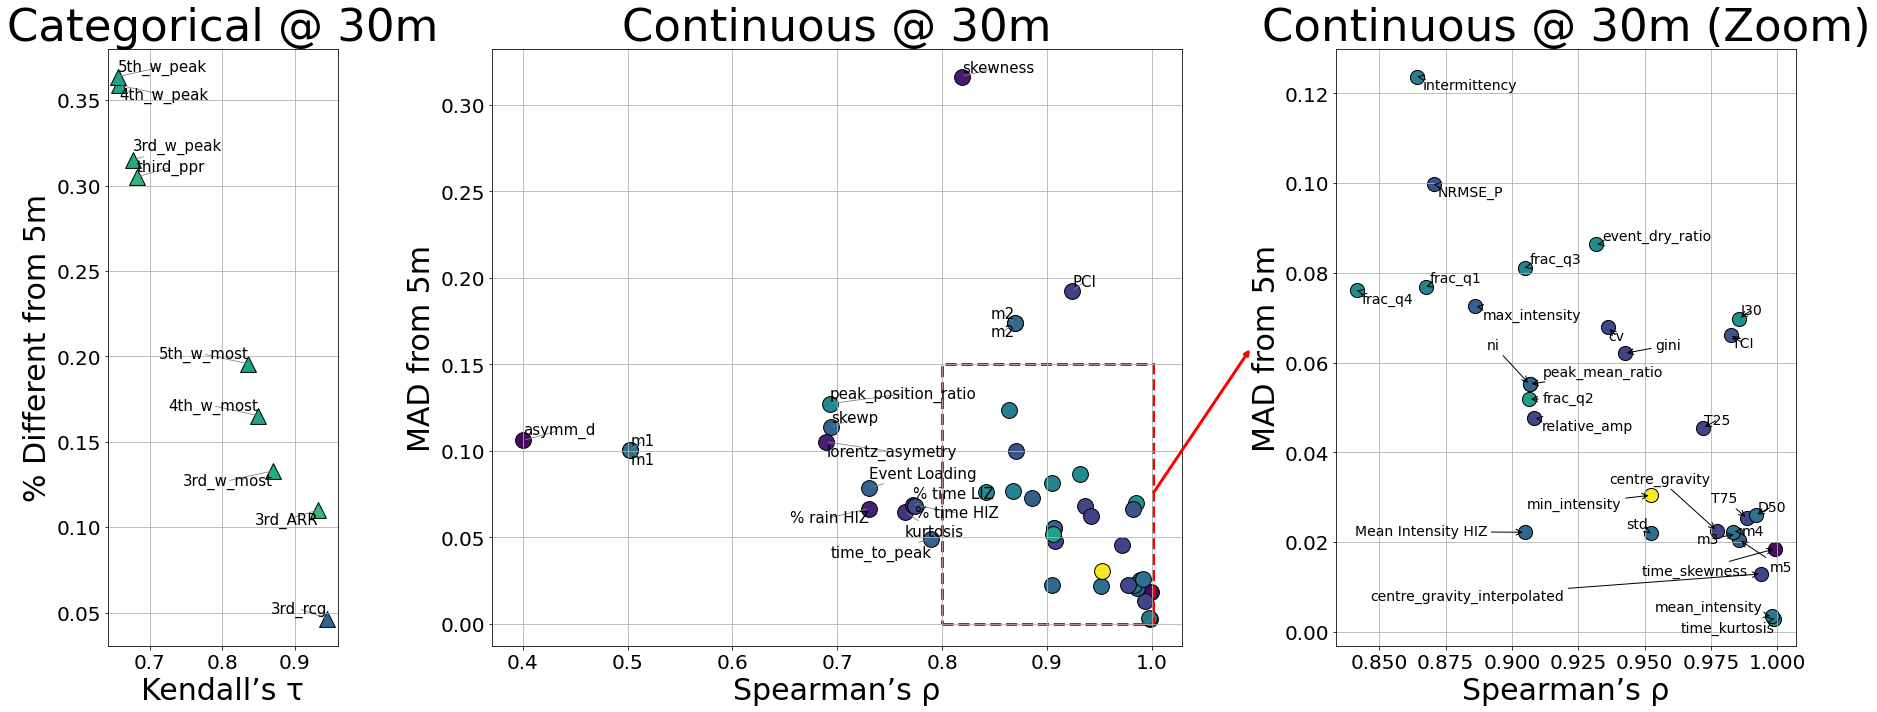

In [244]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text

def scatter_with_labels(ax, data, marker, size, labelsize, title, xlabel, ylabel, exclude_labels=None):
    texts = []
    
    exclude_labels = set(exclude_labels) if exclude_labels else set()
    for _, row in data.iterrows():
        color = cmap(norm(row["gini"]))
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker=marker, s=size, alpha=1)
        if row["metric"] not in exclude_labels:
            metric_name = row["metric"]
            if '_wi' in metric_name:
                metric_name = metric_name.replace('_wi', '')
            texts.append(ax.text(row["rank_corr"], row["val_diff"], metric_name, fontsize=labelsize))
    if "Zoom" in title:
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', lw=1))
    else:
        adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.8),
        force_text=0.7,     # Lower value -> less force to push labels apart
        force_points=0.3,   # Lower value -> labels stay closer to their points
        expand_text=(1.05, 1.2),   # Shrink buffer zone around labels (x, y)
        expand_points=(1.05, 1.2), # Shrink buffer zone around points (x, y)
        only_move={'points': 'y', 'text': 'y'})
    
    ax.set_title(title, fontsize=45)
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Color mapping for Gini
cmap = plt.cm.viridis
gini_min = summary_df['gini'].min()
gini_max = summary_df['gini'].max()
norm = mcolors.Normalize(vmin=gini_min, vmax=gini_max)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(25, 10), gridspec_kw={'width_ratios':[2,6, 4]})

################################## 
# First plot
##################################
resolution = '30m'
subset_cont = summary_df[(summary_df["resolution"] == resolution) & (summary_df["type"] == "categorical")]

# Plot full scatter on ax1
# scatter_with_labels(ax1, subset_cont, 'o',350, 15, f"Continuous @ 10m", "Spearman’s ρ", "MAD from 5m")
scatter_with_labels(ax0, subset_cont, '^', 250, 15,
                    f"Categorical @ {resolution}", "Kendall’s τ", "% Different from 5m",
                    exclude_labels=zoomed_metrics)

################################## 
# Middle plot
##################################
subset_cont = summary_df[(summary_df["resolution"] == resolution) & (summary_df["type"] == "continuous")]
subset_cont = subset_cont[~subset_cont['metric'].isin(['m3', 'm4', 'm5'])]

# Define the zoom box coordinates (adjust these to your area of interest)
x_min, x_max = 0.8, 1.001  
y_min, y_max = 0, 0.15  

# Define zoomed-in data subset
zoomed_data = subset_cont[
    (subset_cont["rank_corr"] >= x_min) & (subset_cont["rank_corr"] <= x_max) &
    (subset_cont["val_diff"] >= y_min) & (subset_cont["val_diff"] <= y_max)
]
zoomed_metrics = zoomed_data["metric"].tolist()

# Plot full scatter on ax1
# scatter_with_labels(ax1, subset_cont, 'o',350, 15, f"Continuous @ 10m", "Spearman’s ρ", "MAD from 5m")
scatter_with_labels(ax1, subset_cont, 'o', 250, 15,
                    f"Continuous @ {resolution}", "Spearman’s ρ", "MAD from 5m",
                    exclude_labels=zoomed_metrics)

# Draw a rectangle box on ax1 to highlight zoomed region
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=3, edgecolor='red', facecolor='none', linestyle='--')
ax1.add_patch(rect)

# Set zoomed axis limits to exactly match the box
# ax1.set_xlim(0.75, 1.01)
# ax1.set_ylim(0, 0.08)

# Get rectangle center on right edge:
x_rect = x_max
y_rect = (y_min + y_max) / 2

# Annotate arrow pointing right toward second subplot:
ax1.annotate(
    '',  # No text
    xy=(1.10, 0.5),  # Relative coordinates just outside ax1's right border, mid height (axes fraction)
    xycoords='axes fraction',
    xytext=(x_rect, y_rect),  # Start arrow at rectangle right edge center (data coords)
    textcoords='data',
    arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=3, alpha=1)
)

################################## 
# End plot
##################################
scatter_with_labels(ax2, zoomed_data, 'o', 200, 14, f"Continuous @ {resolution} (Zoom)", "Spearman’s ρ", "MAD from 5m")

# Set zoomed axis limits to exactly match the box
# ax2.set_xlim(x_min, x_max)
# ax2.set_ylim(y_min, y_max)

# Add a red box around ax2 (the entire subplot area)
bbox_props = dict(boxstyle="square,pad=0.1", ec="red", lw=3, fc="none")
# ax2.text(0.5, 1.02, '', transform=ax2.transAxes, bbox=bbox_props)  # Empty text with bbox to create border

pos = ax2.get_position()
# fig.patches.extend([patches.Rectangle(
#         (pos.x0+0.0635, pos.y0+0.19), pos.width+0.0285, pos.height-0.36,  linestyle='--',
#         fill=False, edgecolor='red', linewidth=3, transform=fig.transFigure, clip_on=False)])
# fig.patches.extend([patches.Rectangle(
#         (pos.x0, pos.y0), pos.width, pos.height,  linestyle='--',
#         fill=False, edgecolor='red', linewidth=3, transform=fig.transFigure, clip_on=False)])

# Adjust aspect ratio of ax2 to match that of the zoom box on ax1
# zoom_box_width = x_max - x_min
# zoom_box_height = y_max - y_min
# ax2.set_aspect(zoom_box_height / zoom_box_width)

plt.tight_layout()
plt.show()

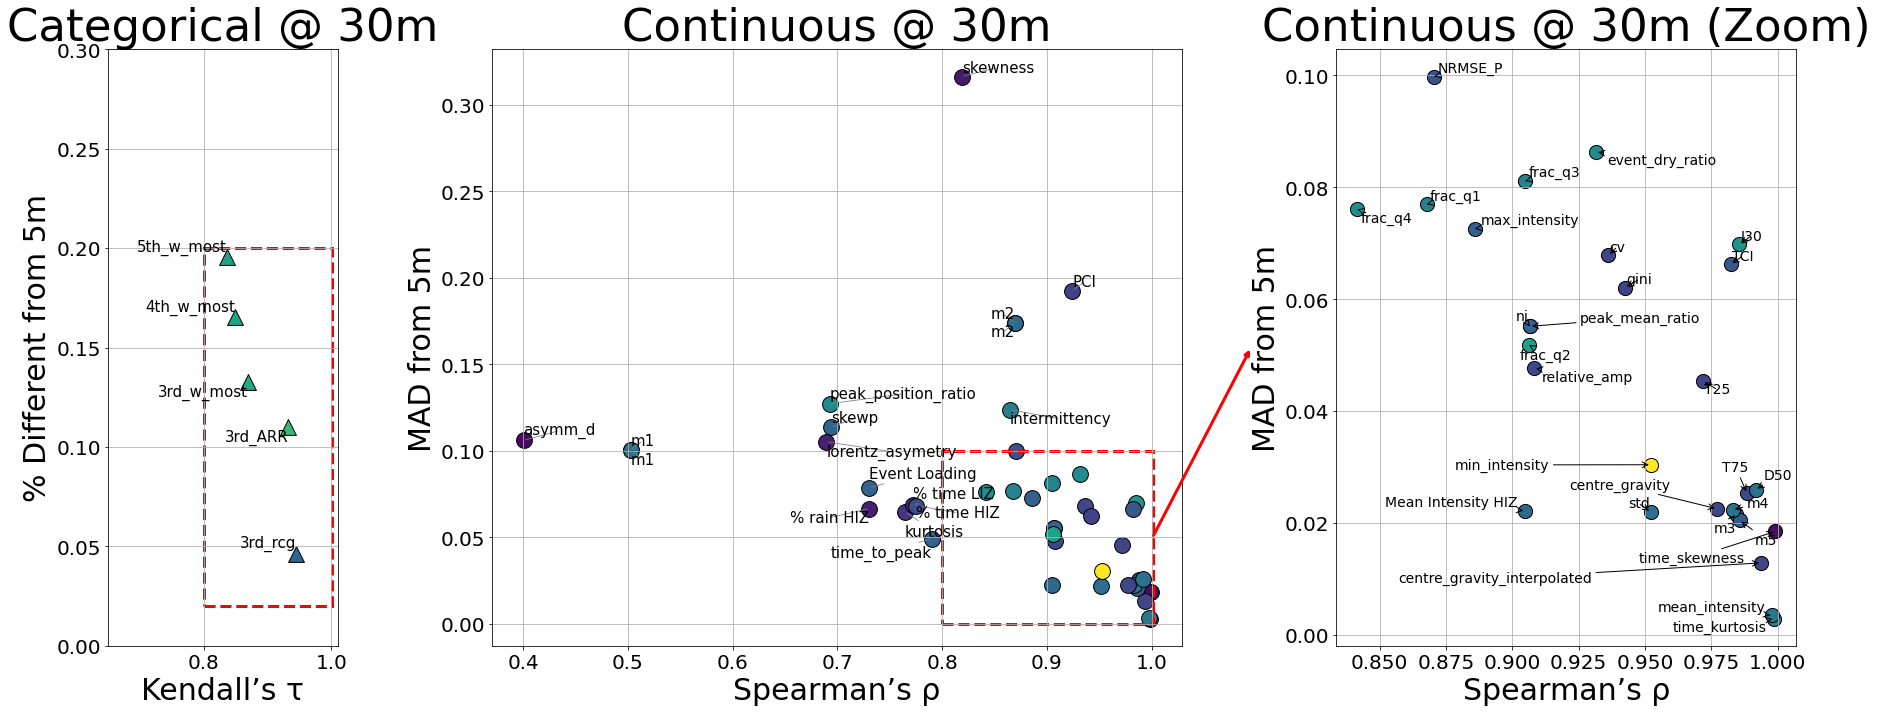

In [253]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text

def scatter_with_labels(ax, data, marker, size, labelsize, title, xlabel, ylabel, exclude_labels=None):
    texts = []
    
    exclude_labels = set(exclude_labels) if exclude_labels else set()
    for _, row in data.iterrows():
        color = cmap(norm(row["gini"]))
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker=marker, s=size, alpha=1)
        if row["metric"] not in exclude_labels:
            metric_name = row["metric"]
            if '_wi' in metric_name:
                metric_name = metric_name.replace('_wi', '')
            texts.append(ax.text(row["rank_corr"], row["val_diff"], metric_name, fontsize=labelsize))
    if "Zoom" in title:
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', lw=1))
    else:
        adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.8),
        force_text=0.7,     # Lower value -> less force to push labels apart
        force_points=0.3,   # Lower value -> labels stay closer to their points
        expand_text=(1.05, 1.2),   # Shrink buffer zone around labels (x, y)
        expand_points=(1.05, 1.2), # Shrink buffer zone around points (x, y)
        only_move={'points': 'y', 'text': 'y'})
    
    ax.set_title(title, fontsize=45)
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Color mapping for Gini
cmap = plt.cm.viridis
gini_min = summary_df['gini'].min()
gini_max = summary_df['gini'].max()
norm = mcolors.Normalize(vmin=gini_min, vmax=gini_max)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(25, 10), gridspec_kw={'width_ratios':[2,6, 4]})

################################## 
# First plot
##################################
resolution = '30m'
subset_cont = summary_df[(summary_df["resolution"] == resolution) & (summary_df["type"] == "categorical")]

# Plot full scatter on ax1
# scatter_with_labels(ax1, subset_cont, 'o',350, 15, f"Continuous @ 10m", "Spearman’s ρ", "MAD from 5m")
scatter_with_labels(ax0, subset_cont, '^', 250, 15,
                    f"Categorical @ {resolution}", "Kendall’s τ", "% Different from 5m",
                    exclude_labels=zoomed_metrics)


x_min, x_max = 0.8, 1.001  
y_min, y_max = 0.02, 0.2  
# Draw a rectangle box on ax1 to highlight zoomed region
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=3, edgecolor='red', facecolor='none', linestyle='--')
ax0.add_patch(rect)

ax0.set_xlim(0.65, 1.01)
ax0.set_ylim(0, 0.3)

################################## 
# Middle plot
##################################
subset_cont = summary_df[(summary_df["resolution"] == resolution) & (summary_df["type"] == "continuous")]
subset_cont = subset_cont[~subset_cont['metric'].isin(['m3', 'm4', 'm5'])]

# Define the zoom box coordinates (adjust these to your area of interest)
x_min, x_max = 0.8, 1.001  
y_min, y_max = 0, 0.1  

# Define zoomed-in data subset
zoomed_data = subset_cont[
    (subset_cont["rank_corr"] >= x_min) & (subset_cont["rank_corr"] <= x_max) &
    (subset_cont["val_diff"] >= y_min) & (subset_cont["val_diff"] <= y_max)
]
zoomed_metrics = zoomed_data["metric"].tolist()

# Plot full scatter on ax1
# scatter_with_labels(ax1, subset_cont, 'o',350, 15, f"Continuous @ 10m", "Spearman’s ρ", "MAD from 5m")
scatter_with_labels(ax1, subset_cont, 'o', 250, 15,
                    f"Continuous @ {resolution}", "Spearman’s ρ", "MAD from 5m",
                    exclude_labels=zoomed_metrics)

# Draw a rectangle box on ax1 to highlight zoomed region
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=3, edgecolor='red', facecolor='none', linestyle='--')
ax1.add_patch(rect)

# Set zoomed axis limits to exactly match the box
# ax1.set_xlim(0.75, 1.01)
# ax1.set_ylim(0, 0.08)

# Get rectangle center on right edge:
x_rect = x_max
y_rect = (y_min + y_max) / 2

# Annotate arrow pointing right toward second subplot:
ax1.annotate(
    '',  # No text
    xy=(1.10, 0.5),  # Relative coordinates just outside ax1's right border, mid height (axes fraction)
    xycoords='axes fraction',
    xytext=(x_rect, y_rect),  # Start arrow at rectangle right edge center (data coords)
    textcoords='data',
    arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=3, alpha=1)
)

################################## 
# End plot
##################################
scatter_with_labels(ax2, zoomed_data, 'o', 200, 14, f"Continuous @ {resolution} (Zoom)", "Spearman’s ρ", "MAD from 5m")

# Set zoomed axis limits to exactly match the box
# ax2.set_xlim(x_min, x_max)
# ax2.set_ylim(y_min, y_max)

# Add a red box around ax2 (the entire subplot area)
bbox_props = dict(boxstyle="square,pad=0.1", ec="red", lw=3, fc="none")
# ax2.text(0.5, 1.02, '', transform=ax2.transAxes, bbox=bbox_props)  # Empty text with bbox to create border

pos = ax2.get_position()
# fig.patches.extend([patches.Rectangle(
#         (pos.x0+0.0635, pos.y0+0.19), pos.width+0.0285, pos.height-0.36,  linestyle='--',
#         fill=False, edgecolor='red', linewidth=3, transform=fig.transFigure, clip_on=False)])
# fig.patches.extend([patches.Rectangle(
#         (pos.x0, pos.y0), pos.width, pos.height,  linestyle='--',
#         fill=False, edgecolor='red', linewidth=3, transform=fig.transFigure, clip_on=False)])

# Adjust aspect ratio of ax2 to match that of the zoom box on ax1
# zoom_box_width = x_max - x_min
# zoom_box_height = y_max - y_min
# ax2.set_aspect(zoom_box_height / zoom_box_width)

plt.tight_layout()
plt.show()

In [262]:
summary_df[summary_df['type']=="continuous"]['val_diff'].max()

0.4838756570998605

In [5]:
def plot_metric_sensitivity_2d_with_gini(summary_df, summary_df_high, resolutions=["10m", "30m", "60m"]):
    n_rows = len(resolutions)
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4 * n_rows), sharex=False, sharey=False)

    gini_min = summary_df['gini'].min()
    gini_max = summary_df['gini'].max()
    norm = mcolors.Normalize(vmin=gini_min, vmax=gini_max)
    cmap = plt.cm.viridis

    for i, res in enumerate(resolutions):
        ax_cat, ax_cont, ax_high = axes[i, 0], axes[i, 1], axes[i, 2]

        def scatter_with_labels(ax, data, marker, title, xlabel, ylabel):
            for _, row in data.iterrows():
                color = cmap(norm(row["gini"]))
                ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black', marker=marker, s=90, alpha=1)
                # Add label with offset to reduce overlap
                ax.annotate(row["metric"], (row["rank_corr"], row["val_diff"]),
                            textcoords="offset points", xytext=(4, 2),
                            ha='left', fontsize=6, alpha=0.9)
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.grid(True)

        subset_cat = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == "categorical")]
        scatter_with_labels(ax_cat, subset_cat, '^', f"Categorical/Ordinal @ {res}", "Kendall’s τ", "% Different from 5m")

        subset_cont = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == "continuous")]
        scatter_with_labels(ax_cont, subset_cont, 'o', f"Continuous @ {res}", "Spearman’s ρ", "MAD from 5m")

        subset_high = summary_df_high[(summary_df_high["resolution"] == res)]
        scatter_with_labels(ax_high, subset_high, 'o', f"High Agreement @ {res}", "Spearman’s ρ", "MAD from 5m")

    # Add a colorbar that respects tight layout
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.015, pad=0.04)
    cbar.set_label('Gini Coefficient')

    plt.tight_layout()
    plt.show()


In [6]:
# --- Helper function to split column name into metric and resolution --- #
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found


In [7]:


def compute_metric_sensitivity(df, continuous_metrics, categorical_metrics, resolutions=["10m", "30m", "60m"]):
    rows = []

    for res in resolutions:
        for metric in continuous_metrics + categorical_metrics:
            ref_col = f"{metric}_5m"
            comp_col = f"{metric}_{res}"
            if ref_col not in df.columns or comp_col not in df.columns:
                continue

            x_vals = df[ref_col]
            y_vals = df[comp_col]
            valid = x_vals.notna() & y_vals.notna()
            x = x_vals[valid]
            y = y_vals[valid]

            if len(x) < 2:
                continue

            is_continuous = metric in continuous_metrics
            if is_continuous:
                rank_corr, _ = spearmanr(x, y)
                val_diff = np.mean(np.abs(y - x))  # MAD
            else:
                rank_corr, _ = kendalltau(x, y)
                observed_diff = np.mean(x != y) * 100  # raw % different

                # Option A: Normalize based on number of classes in 5-min data
                n_classes = x.nunique()
                if n_classes > 1:
                    max_diff = (1 - 1 / n_classes) * 100  # convert to percent
                    val_diff = observed_diff / max_diff  # normalized disagreement
                else:
                    val_diff = 0  # No disagreement possible if only one class

            spread = gini(y)

            rows.append({
                "metric": metric,
                "resolution": res,
                "type": "continuous" if is_continuous else "categorical",
                "rank_corr": rank_corr,
                "val_diff": val_diff,
                "gini": spread
            })

    return pd.DataFrame(rows)

In [8]:
def plot_metric_sensitivity_2d(summary_df, resolutions=["10m", "30m", "60m"]):
    n_rows = len(resolutions)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows), sharex='col', sharey='col')

    for i, res in enumerate(resolutions):
        for j, (metric_type, title) in enumerate([
            ("categorical", "Categorical/Ordinal Metrics"),
            ("continuous", "Continuous Metrics")
        ]):
            ax = axes[i, j]

            subset = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == metric_type)]
            for _, row in subset.iterrows():
                color = 'tab:orange' if metric_type == 'categorical' else 'tab:blue'
                marker = '^' if metric_type == 'categorical' else 'o'
                ax.scatter(row["rank_corr"], row["val_diff"], color=color, marker=marker, s=60, alpha=0.8)
                ax.text(row["rank_corr"], row["val_diff"], row["metric"], fontsize=7, alpha=0.7)

            ax.set_xlim(0.2, 1)
            ax.set_title(f"{title} at {res}")
            xlabel = "Kendall’s τ" if metric_type == "categorical" else "Spearman’s ρ"
            ylabel = "% Different from 5m" if metric_type == "categorical" else "MAD from 5m"
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.grid(True)

    plt.tight_layout()
    plt.suptitle("Metric Sensitivity Across Temporal Resolutions (2D)", y=1.02, fontsize=16)
    plt.show()

def plot_metric_sensitivity_3d(summary_df, resolutions=["10m", "30m", "60m"]):
    n_rows = len(resolutions)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows), subplot_kw={'projection': '3d'}, sharex=False, sharey=False)

    for res_idx, res in enumerate(resolutions):
        for metric_type_index, (metric_type, title) in enumerate([
            ("categorical", "Categorical/Ordinal Metrics"),
            ("continuous", "Continuous Metrics")
        ]):
            ax = axes[res_idx, metric_type_index]

            subset = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == metric_type)]
            for _, row in subset.iterrows():
                color = 'tab:orange' if metric_type == 'categorical' else 'tab:blue'
                marker = '^' if metric_type == 'categorical' else 'o'
                ax.scatter(row["rank_corr"], row["val_diff"], row["gini"], color=color, marker=marker, s=50, alpha=0.8)
                ax.text(row["rank_corr"], row["val_diff"], row["gini"], row["metric"], fontsize=7, alpha=0.7)

                # Add vertical projection line ("shadow") down to z = zmin:
                # ax.plot([row["rank_corr"], row["val_diff"]], [row["val_diff"], row["val_diff"]], [row["gini"], 0], 
                #         color='gray', alpha=0.3, linestyle='--')
            
            ax.set_xlim(0, 1)
            if metric_type_index ==0:
                ax.set_ylim(0, 30)
            xlabel = "Kendall’s τ" if metric_type == "categorical" else "Spearman’s ρ"
            ylabel = "% Different from 5m" if metric_type == "categorical" else "MAD from 5m"
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_zlabel("Gini Index")
            ax.set_title(f"{title} at {res}")
            ax.grid(True)
            ax.view_init(elev=20, azim=5)

    plt.tight_layout()
    plt.suptitle("Metric Sensitivity Across Temporal Resolutions (3D)", y=1.02, fontsize=16)
    plt.show()


# def plot_metric_sensitivity_2d_with_gini(summary_df, resolutions=["10m", "30m", "60m"]):
#     n_rows = len(resolutions)
#     fig, axes = plt.subplots(n_rows, 2, figsize=(18, 4 * n_rows), sharex='col', sharey='col')

#     # Normalize gini values across entire dataframe for consistent color mapping
#     gini_min = summary_df['gini'].min()
#     gini_max = summary_df['gini'].max()
#     norm = mcolors.Normalize(vmin=gini_min, vmax=gini_max)
#     cmap = plt.cm.Blues

#     for i, res in enumerate(resolutions):
#         for j, (metric_type, title) in enumerate([
#             ("categorical", "Categorical/Ordinal Metrics"),
#             ("continuous", "Continuous Metrics")
#         ]):
#             ax = axes[i, j]

#             subset = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == metric_type)]

#             for _, row in subset.iterrows():
#                 color = cmap(norm(row["gini"]))
#                 marker = '^' if metric_type == 'categorical' else 'o'
#                 ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black', marker=marker, s=60, alpha=1)
#                 ax.text(row["rank_corr"], row["val_diff"], row["metric"], fontsize=7, alpha=1)

#             # ax.set_xlim(0, 1)
#             ax.set_title(f"{title} @ {res}")
                
#             xlabel = "Kendall’s τ" if metric_type == "categorical" else "Spearman’s ρ"
#             ylabel = "% Different from 5m" if metric_type == "categorical" else "MAD from 5m"
#             ax.set_xlabel(xlabel)
#             ax.set_ylabel(ylabel)
#             ax.grid(True)

#     # Create a colorbar for gini
#     cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, cax=cbar_ax)
#     cbar.set_label('Gini Coefficient')

#     plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
#     plt.show()


In [9]:
def compute_val_diff_categorical(df, categorical_metrics, resolutions):
    val_diff_results = {res: [] for res in resolutions if res != '5m'}
    for metric in categorical_metrics:
        ref = df[f"{metric}_5m"]
        for res in val_diff_results:
            col = f"{metric}_{res}"
            if col in df.columns:
                comp = df[col]
                valid = ref.notna() & comp.notna()
                x = ref[valid]
                y = comp[valid]
                if len(x) == 0:
                    val_diff = np.nan
                else:
                    observed_diff = (x != y).mean() * 100
                    n_classes = x.nunique()
                    max_diff = (1 - 1 / n_classes) * 100 if n_classes > 1 else 1
                    val_diff = observed_diff / max_diff  # normalized disagreement (0–1)
                val_diff_results[res].append(val_diff)
            else:
                val_diff_results[res].append(np.nan)
    return pd.DataFrame(val_diff_results, index=categorical_metrics)


def compute_mad_relative_to_5m(df, continuous_metrics, resolutions):
    mad_results = {res: [] for res in resolutions if res != '5m'}
    for metric in continuous_metrics:
        ref = df[f"{metric}_5m"]
        for res in mad_results:
            col = f"{metric}_{res}"
            if col in df.columns:
                comp = df[col]
                diff = np.abs(comp - ref)
                mad_results[res].append(diff.mean())
            else:
                mad_results[res].append(np.nan)
    return pd.DataFrame(mad_results, index=continuous_metrics)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from scipy.interpolate import interp1d
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp
import pickle
import datetime 
import warnings
import sys
import re
import matplotlib.colors as mcolors
import seaborn as sns

from datetime import timedelta
import skill_metrics as sm
warnings.simplefilter(action='ignore', category=FutureWarning)

# from ClassFunctions_OtherRes import precip_time_series, rainfall_analysis
sys.path.insert(0, '../')
from PlottingFunctions import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [146]:
transformed_minmax_scaled = pd.read_csv("../../test.csv")
# for col in ['m2', 'm3', 'm4', 'm5']:
# #     cols_to_drop = transformed_minmax_scaled.columns[transformed_minmax_scaled.columns.str.contains(col)]
#     cols_to_drop = transformed_minmax_scaled.columns[transformed_minmax_scaled.columns.str.endswith(col)]
#     transformed_minmax_scaled.drop(cols_to_drop, axis=1, inplace=True)

In [231]:
# transformed_minmax_scaled[['gini_5m','lorentz_asymetry_5m',]]

In [232]:
# transformed_minmax_scaled[['time_to_peak_5m','peak_position_ratio_5m','skewp_5m']]

In [233]:
# transformed_minmax_scaled[['peak_mean_ratio_5m', 'ni_5m', 'm2_5m', 'relative_amp_5m']]

In [147]:
column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

In [148]:
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = list(metrics)
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in metrics if metric not in categorical_metrics]
continuous_metrics.remove('T50')

continuous_metrics.remove('BSC_Index')
continuous_metrics.remove('BSC')

### Compute the chosen statistical tests 

In [149]:
summary_df = compute_metric_sensitivity(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics,
    resolutions=["10m", "30m", "60m"])

In [117]:
summary_df_high =summary_df[(summary_df['rank_corr']>0.95) & (summary_df['val_diff']<0.01)]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


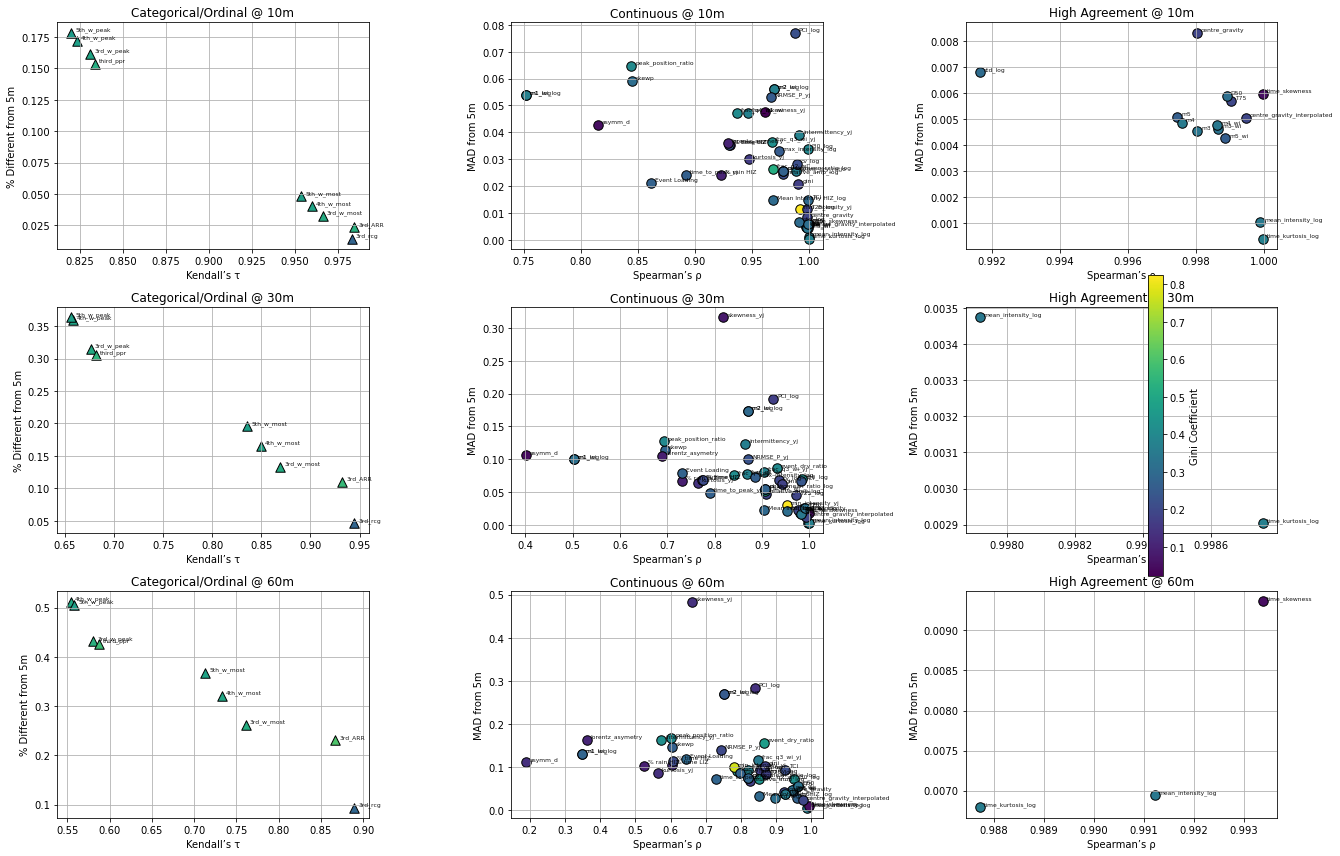

In [15]:
plot_metric_sensitivity_2d_with_gini(summary_df, summary_df_high)

### Other plots - metic by metric

In [ ]:
resolutions = ['5m', '10m', '30m', '60m']

val_diff_df = compute_val_diff_categorical(transformed_minmax_scaled, categorical_metrics, resolutions)
mad_df = compute_mad_relative_to_5m(transformed_minmax_scaled, continuous_metrics, resolutions)

val_diff_df.sort_values(by='60m', inplace=True)
mad_df.sort_values(by='60m', inplace=True)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left: categorical
for res in val_diff_df.columns:
    axes[0].plot(val_diff_df.index, val_diff_df[res], marker='o', label=res)
axes[0].set_title('Categorical Metrics: Normalized % Disagreement')
axes[0].set_ylabel('Normalized Disagreement (0–1)')
axes[0].set_xticklabels(val_diff_df.index, rotation=90)
axes[0].legend()
axes[0].grid(True)

# Right: continuous
for res in mad_df.columns:
    axes[1].plot(mad_df.index, mad_df[res], marker='o', label=res)
axes[1].set_title('Continuous Metrics: Mean Absolute Difference vs 5m')
axes[1].set_ylabel('MAD')
axes[1].set_xticklabels(mad_df.index, rotation=90)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def plot_metric_histograms(transformed_df, metrics, resolutions=["5m", "10m", "30m", "60m"]):
    import matplotlib.pyplot as plt
    import seaborn as sns

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for res in resolutions:
            col = f"{metric}_{res}"
            if col in transformed_df.columns:
                sns.histplot(transformed_df[col], kde=False, label=res, bins=30, alpha=0.6)
        plt.title(f"Histogram of {metric} across resolutions")
        plt.xlabel("Metric value")
        plt.ylabel("Count")
        plt.legend(title="Resolution")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
def plot_violin_comparison(transformed_df, metric, resolutions=["5m", "10m", "30m", "60m"]):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    plot_df = pd.DataFrame({
        "value": [],
        "resolution": []
    })

    for res in resolutions:
        col = f"{metric}_{res}"
        if col in transformed_df.columns:
            plot_df = plot_df.append(pd.DataFrame({
                "value": transformed_df[col],
                "resolution": res
            }))

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=plot_df, x="resolution", y="value", inner="box", palette="Set2")
    plt.title(f"Violin plot of {metric} across resolutions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
        
        
plot_violin_comparison(transformed_minmax_scaled, continuous_metrics)

In [ ]:
# Ensure metrics are sorted by magnitude at 60m (for visual clarity)
val_diff_sorted = val_diff_df.sort_values(by='60m', ascending=False)
mad_sorted = mad_df.sort_values(by='60m', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# Categorical Heatmap: Normalized % Disagreement
sns.heatmap(
    val_diff_sorted,
    ax=axes[0],
    cmap='YlOrRd',
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Disagreement"},
    vmin=0,
    vmax=1
)
axes[0].set_title("Categorical Metrics: Normalized % Disagreement")
axes[0].set_xlabel("Resolution")
axes[0].set_ylabel("Metric")

# Continuous Heatmap: MAD from 5m
sns.heatmap(
    mad_sorted,
    ax=axes[1],
    cmap='PuBuGn',
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Mean Absolute Difference"},
)
axes[1].set_title("Continuous Metrics: Mean Absolute Difference vs 5m")
axes[1].set_xlabel("Resolution")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_metric_sensitivity_2x3_with_gini(summary_df):
    # Separate data by type
    cat_df = summary_df[summary_df["type"] == "categorical"]
    cont_df = summary_df[summary_df["type"] == "continuous"]

    # Define metric matrices for all three measures
    def pivot_and_sort(df, value_col):
        pivot = df.pivot(index="metric", columns="resolution", values=value_col)
        if '60m' in pivot.columns:
            pivot = pivot.sort_values(by='60m', ascending=(value_col != "rank_corr"))
        else:
            pivot['mean'] = pivot.mean(axis=1)
            pivot = pivot.sort_values('mean', ascending=(value_col != "rank_corr"))
            pivot.drop(columns='mean', inplace=True)
        return pivot

    cat_val_diff = pivot_and_sort(cat_df, "val_diff")
    cat_rank_corr = pivot_and_sort(cat_df, "rank_corr")
    cat_gini = pivot_and_sort(cat_df, "gini")

    cont_val_diff = pivot_and_sort(cont_df, "val_diff")
    cont_rank_corr = pivot_and_sort(cont_df, "rank_corr")
    cont_gini = pivot_and_sort(cont_df, "gini")

    # Keep consistent row order for each type
    cat_metrics = cat_val_diff.index
    cont_metrics = cont_val_diff.index
    cat_rank_corr = cat_rank_corr.loc[cat_metrics]
    cat_gini = cat_gini.loc[cat_metrics]
    cont_rank_corr = cont_rank_corr.loc[cont_metrics]
    cont_gini = cont_gini.loc[cont_metrics]

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(24, 14))

    def annotate_best(ax, data, best_func=np.min, cmap='coolwarm'):
        vals = data.values
        mask = np.zeros_like(vals, dtype=bool)
        if best_func == np.max:
            best_val = np.nanmax(vals)
        else:
            best_val = np.nanmin(vals)
        best_idx = np.where(vals == best_val)
        for y, x in zip(*best_idx):
            ax.text(x + 0.5, y + 0.5, "*", ha='center', va='center', fontsize=16, color='black')


    heatmap_settings = [
        # Row 0: categorical
        (cat_val_diff, "Normalized % Disagreement", "YlOrRd", 0, 0, (0, 1), np.min),
        (cat_rank_corr, "Kendall’s τ vs 5m", "YlGnBu", 0, 1, (0.5, 1), np.max),
        (cat_gini, "Gini Index", "OrRd", 0, 2, (0, 1), np.min),
        # Row 1: continuous
        (cont_val_diff, "MAD from 5m", "PuBuGn", 1, 0, None, np.min),
        (cont_rank_corr, "Spearman’s ρ vs 5m", "YlGnBu", 1, 1, (0.5, 1), np.max),
        (cont_gini, "Gini Index", "OrRd", 1, 2, (0, 1), np.min),
    ]

    for data, title, cmap, row, col, vrange, best_func in heatmap_settings:
        ax = axes[row, col]
        sns.heatmap(data, annot=True, fmt=".2f", cmap=cmap,
                    cbar_kws={"label": title.split(":")[0]},
                    vmin=vrange[0] if vrange else None,
                    vmax=vrange[1] if vrange else None,
                    ax=ax)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Resolution", fontsize=12)
        ax.set_ylabel("" if col == 0 else "")
        ax.tick_params(axis='y', labelrotation=0)
        annotate_best(ax, data, best_func)

    plt.tight_layout()
    plt.show()

    
plot_metric_sensitivity_2x3_with_gini(summary_df)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_rank_corr_heatmaps_from_summary(summary_df, cmap):
    # Split into categorical and continuous
    cat_df = summary_df[summary_df["type"] == "categorical"]
    cont_df = summary_df[summary_df["type"] == "continuous"]

    # Pivot: index = metric, columns = resolution, values = rank_corr
    cat_matrix = cat_df.pivot(index="metric", columns="resolution", values="rank_corr")
    cont_matrix = cont_df.pivot(index="metric", columns="resolution", values="rank_corr")

    # Sort rows by average rank correlation (descending)
    cat_matrix["mean_corr"] = cat_matrix.mean(axis=1)
    cont_matrix["mean_corr"] = cont_matrix.mean(axis=1)
    cat_matrix.sort_values("mean_corr", ascending=False, inplace=True)
    cont_matrix.sort_values("mean_corr", ascending=False, inplace=True)
    cat_matrix.drop(columns="mean_corr", inplace=True)
    cont_matrix.drop(columns="mean_corr", inplace=True)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(18, max(5, 0.3 * max(len(cat_matrix), len(cont_matrix)))))
    sns.heatmap(cat_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=0.5, vmax=1, ax=axes[0], annot_kws={"size": 20})
    axes[0].set_title("Categorical/Ordinal Metrics (Kendall's τ)", fontsize=25)
    axes[0].set_xlabel("Resolution vs 5m", fontsize=15)
    axes[0].set_ylabel("")
    labels = list(cat_df['metric'].unique())
    axes[0].set_yticklabels(labels, rotation=0, ha='right')
    axes[0].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
    
    sns.heatmap(cont_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=0.5, vmax=1, ax=axes[1], annot_kws={"size": 20})
    axes[1].set_title("Continuous Metrics (Spearman’s ρ)", fontsize=25)
    axes[1].set_xlabel("Resolution vs 5m", fontsize=15)
    axes[1].set_ylabel("")

    axes[1].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
    
    
    plt.tight_layout()
    plt.show()

# Ensure metrics are sorted by magnitude at 60m (for visual clarity)
val_diff_sorted = val_diff_df.sort_values(by='60m', ascending=False)
mad_sorted = mad_df.sort_values(by='60m', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# Categorical Heatmap: Normalized % Disagreement
sns.heatmap(
    val_diff_sorted,
    ax=axes[0],
    cmap='YlOrRd',
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Disagreement"},
    vmin=0,
    vmax=1
)
axes[0].set_title("Categorical Metrics: Normalized % Disagreement")
axes[0].set_xlabel("Resolution")
axes[0].set_ylabel("Metric")

# Continuous Heatmap: MAD from 5m
sns.heatmap(
    mad_sorted,
    ax=axes[1],
    cmap='PuBuGn',
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Mean Absolute Difference"},
)
axes[1].set_title("Continuous Metrics: Mean Absolute Difference vs 5m")
axes[1].set_xlabel("Resolution")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


plot_rank_corr_heatmaps_from_summary(summary_df, "YlOrRd")

In [ ]:
# Step 2: Compute average Spearman correlation for each metric
metric_corrs = []
for metric in metrics:
    try:
        # Create a DataFrame with all resolutions of this metric
        data = pd.DataFrame({
            res: transformed_minmax_scaled[f"{metric}_{res}"] for res in resolutions
        })

        corr_matrix = data.corr(method='spearman')
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        mean_corr = upper_tri.stack().mean()  # average of upper triangle (pairwise correlations)
        metric_corrs.append((metric, mean_corr))
    except KeyError:
        continue  # Skip metric if any resolution is missing

# Step 3: Sort metrics by descending average correlation
sorted_metrics = [m for m, _ in sorted(metric_corrs, key=lambda x: -x[1])]

# Step 4: Plot heatmaps with sorted metric order
fig, axs = plt.subplots(12, 5, figsize=(12, 20))
axs = axs.flatten()

for i, metric in enumerate(sorted_metrics):
    try:
        data = pd.DataFrame({
            res: transformed_minmax_scaled[f"{metric}_{res}"] for res in resolutions
        })
        corr = data.corr(method='spearman')
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[i], vmin=0.5, vmax=1)
        axs[i].set_title(f"{metric}")
    except KeyError:
        axs[i].axis('off')  # In case of missing data

# Hide any extra axes
for j in range(len(sorted_metrics), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# # Example: column names like "3rd_rcg_5m", "3rd_rcg_10m", etc.
# metric_base = "3rd_w_peak"
# resolutions = ["5m", "10m", "30m", "60m"]
# df = all_events_all_res

# # Count values
# value_counts = pd.DataFrame({
#     res: df[f"{metric_base}_{res}"].value_counts(normalize=True)
#     for res in resolutions
# }).fillna(0)

# # Reindex columns to ensure order: 1, 2, 3
# value_counts = value_counts.reindex([1, 2, 3], axis=0)

# # Plot
# value_counts.T.plot(kind='bar', stacked=True, colormap='Set2')
# plt.title("Distribution of '3rd_rcg' across resolutions")
# plt.ylabel("Proportion of Events")
# plt.xlabel("Resolution")
# plt.legend(title="Third with CoM", loc='upper right')
# plt.tight_layout()
# plt.show()
